In [1]:
import os
import librosa
import pandas as pd
import numpy as np
import json
import torch
import torchaudio
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from IPython.display import Audio
from transformers import Wav2Vec2Processor, Wav2Vec2Model, Wav2Vec2ForSequenceClassification
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

from sklearn.manifold import TSNE
import umap.umap_ as umap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import colormaps

from functions import AudioMNISTDataset, create_dataloaders, collate_fn

from scipy.spatial.distance import pdist, squareform

from scipy.spatial.distance import cdist

import time
from sklearn.metrics import davies_bouldin_score
import plotly.graph_objects as go
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
def plot_tsne(features, labels, n_components=2, perplexity=30, learning_rate=200, max_iter=1000, random_state=42, title="t-SNE Projection of Features"):
    # Ensure 'features' and 'labels' are numpy arrays
    assert isinstance(features, np.ndarray), "Features must be a numpy array"
    assert isinstance(labels, np.ndarray), "Labels must be a numpy array"

    # t-SNE Projection
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, max_iter=max_iter, random_state=random_state)
    tsne_embeddings = tsne.fit_transform(features)

    # Set colormap based on number of unique labels
    if len(np.unique(labels)) == 2:
        cmap_rg = ListedColormap(["red", "green"])
        cmap = cmap_rg
    else:
        cmap = 'tab10'
    
    # Plot t-SNE
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap=cmap, s=5)
    plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.show()
    
def plot_umap(features, labels, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection of Features",show=True, save=False, idx=None):
    """
    Plot a UMAP projection of features with labels. Includes a legend for two-class data.
    
    Parameters:
        features (np.ndarray): Feature matrix of shape (n_samples, n_features).
        labels (np.ndarray): Labels corresponding to each sample.
        n_neighbors (int): Number of neighbors for UMAP.
        min_dist (float): Minimum distance for UMAP embedding.
        n_components (int): Number of components for UMAP projection.
        random_state (int): Random seed for reproducibility.
        title (str): Title of the plot.
    """
    # Ensure 'features' and 'labels' are numpy arrays
    assert isinstance(features, np.ndarray), "Features must be a numpy array"
    assert isinstance(labels, np.ndarray), "Labels must be a numpy array"

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)

    # Determine colormap and handle for two-class or multi-class labels
    unique_labels = np.unique(labels)
    if len(unique_labels) == 2:
        cmap = ListedColormap(["red", "green"])
    else:
        cmap = 'tab10'
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap=cmap, s=5, label=unique_labels)
    
    # Add legend for two-class data
    handles = []
    for i, label in enumerate(unique_labels):
        handles.append(plt.Line2D([], [], color=cmap(i), marker='o', linestyle='', markersize=5, label=f"{'Female' if label else 'Male'}"))
    plt.legend(handles=handles, title="Classes")
    
    # Optional: Add colorbar for multi-class data
    # plt.colorbar(scatter)
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    if save:
        plt.savefig(f'UMAP {idx}')
    if show:
        plt.show()

def forward_pass(model, dataloader, metadata):
    """
    Perform a forward pass and collect metadata along with labels.
    
    Args:
        model: The model to run the forward pass on.
        dataloader: A PyTorch DataLoader for the dataset.
        metadata: Metadata dictionary loaded from audioMNIST_meta.json.
    
    Returns:
        result: A list of dictionaries, each containing label, file path, and metadata.
    """
    result = []
    with torch.no_grad():
        for batch in dataloader:
            input_values, labels, file_paths = batch  # File paths are now returned by the DataLoader
            input_values = input_values.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(input_values)

            # Process metadata for each file
            for label, file_path in zip(labels.cpu().numpy(), file_paths):
                # Extract speaker ID from the file path
                speaker_id = os.path.basename(os.path.dirname(file_path))
                speaker_metadata = metadata.get(speaker_id, {})
                
                # Append metadata, label, and file info
                result.append({
                    "label": int(label),
                    "file_path": file_path,
                    "metadata": speaker_metadata,
                    "speaker_id": speaker_id
                })
    return result

def hook(module, input, output):
    # Apply mean pooling over the sequence length dimension (dim=1)
    pooled_output = output[1].mean(dim=1)  # Shape: [batch_size, 768]
    projector_features.append(pooled_output.detach())
    
def register_hook(layer):
    """
    Registers a forward hook to store features in the dynamically provided storage.

    Args:
        layer (nn.Module): The layer to which the hook should be attached.
        feature_storage (list): A mutable list to store the features extracted by the hook.
    
    Returns:
        hook_handle (torch.utils.hooks.RemovableHandle): Handle to manage the hook lifecycle.
    """
    feature_storage = []
    def hook(module, input, output):
        
        if isinstance(output, tuple):
            if isinstance(output[0], torch.Tensor):
                output = output[0]
            elif isinstance(output[1], torch.Tensor):
                output = output[1]
            elif isinstance(output[2], torch.Tensor):
                output = output[3]
        #elif isinstance(output, tuple):
        #    print("ok")
        else:
            raise ValueError('Bad format')
        
        #elif isinstance(output, torch.Tensor):
            # do nothing - output is correct

        # Apply mean pooling over the sequence length dimension (dim=1)
        pooled_output = output.mean(dim=1)  # Shape: [batch_size, 768]
        feature_storage.append(pooled_output.detach())  # Append the pooled output to the passed storage

    # Register the hook
    hook_handle = layer.register_forward_hook(hook)
    return hook_handle, feature_storage

In [3]:
# Load the metadata
with open("audioMNIST_meta.json", "r") as f:
    metadata = json.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base")

dataloaders = create_dataloaders("AudioMNIST/data/", processor, batch_size=16)

train_loader = dataloaders["train"]
val_loader = dataloaders["val"]
test_loader = dataloaders["test"]

In [4]:
x, lab, pth = next(iter(train_loader))
print(x.shape)

torch.Size([16, 14728])


In [5]:
# Load saved model
model1 = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=10)
model1.load_state_dict(torch.load("seq-class-head.pth", weights_only=True))
model1.to(device)
model1.eval()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


### UMAP of model1 (only class head)

In [10]:
hook0_s.shape

torch.Size([6000, 768])

In [6]:
# Hook features
hook0, hook0_s = register_hook(model1.wav2vec2.feature_projection)
hook1, hook1_s = register_hook(model1.wav2vec2.encoder.layers[0].attention)
hook2, hook2_s = register_hook(model1.wav2vec2.encoder.layers[1].attention)
hook3, hook3_s = register_hook(model1.wav2vec2.encoder.layers[2].attention)
hook4, hook4_s = register_hook(model1.wav2vec2.encoder.layers[3].attention)
hook5, hook5_s = register_hook(model1.wav2vec2.encoder.layers[4].attention)
hook6, hook6_s = register_hook(model1.wav2vec2.encoder.layers[5].attention)
hook7, hook7_s = register_hook(model1.wav2vec2.encoder.layers[6].attention)
hook8, hook8_s = register_hook(model1.wav2vec2.encoder.layers[7].attention)
hook9, hook9_s = register_hook(model1.wav2vec2.encoder.layers[8].attention)
hook10, hook10_s = register_hook(model1.wav2vec2.encoder.layers[9].attention)
hook11, hook11_s = register_hook(model1.wav2vec2.encoder.layers[10].attention)
hook12, hook12_s = register_hook(model1.wav2vec2.encoder.layers[11].attention)

data_dict = forward_pass(model1, test_loader, metadata)

# Remove the hook after extraction
hook0.remove()
hook1.remove()
hook2.remove()
hook3.remove()
hook4.remove()
hook5.remove()
hook6.remove()
hook7.remove()
hook8.remove()
hook9.remove()
hook10.remove()
hook11.remove()
hook12.remove()

# Stack the collected features and labels
hook0_s = torch.cat(hook0_s, dim=0)
hook1_s = torch.cat(hook1_s, dim=0)
hook2_s = torch.cat(hook2_s, dim=0)
hook3_s = torch.cat(hook3_s, dim=0)
hook4_s = torch.cat(hook4_s, dim=0)
hook5_s = torch.cat(hook5_s, dim=0)
hook6_s = torch.cat(hook6_s, dim=0)
hook7_s = torch.cat(hook7_s, dim=0)
hook8_s = torch.cat(hook8_s, dim=0)
hook9_s = torch.cat(hook9_s, dim=0)
hook10_s = torch.cat(hook10_s, dim=0)
hook11_s = torch.cat(hook11_s, dim=0)
hook12_s = torch.cat(hook12_s, dim=0)

labels = [entry['label'] for entry in data_dict]
labels_np = np.array(labels)
metadata_dict = [entry['metadata'] for entry in data_dict]
speaker_ids = [entry['speaker_id'] for entry in data_dict]
sid_np = np.array(speaker_ids)

# Convert to NumPy for UMAP
hook0_n = hook0_s.cpu().numpy()
hook1_n = hook1_s.cpu().numpy()
hook2_n = hook2_s.cpu().numpy()
hook3_n = hook3_s.cpu().numpy()
hook4_n = hook4_s.cpu().numpy()
hook5_n = hook5_s.cpu().numpy()
hook6_n = hook6_s.cpu().numpy()
hook7_n = hook7_s.cpu().numpy()
hook8_n = hook8_s.cpu().numpy()
hook9_n = hook9_s.cpu().numpy()
hook10_n = hook10_s.cpu().numpy()
hook11_n = hook11_s.cpu().numpy()
hook12_n = hook12_s.cpu().numpy()

In [7]:
# Reformat the metadata

accents = [entry['accent'] for entry in metadata_dict]
ages = [entry['age'] for entry in metadata_dict]
genders = [entry['gender'] for entry in metadata_dict]
native = [entry['native speaker'] for entry in metadata_dict]
origins = [entry['origin'] for entry in metadata_dict]

genders_np = np.array(genders)

gender_bin = np.zeros(len(genders_np))
for i, gen in enumerate(genders_np):
    if gen == 'male':
        gender_bin[i] = 0
    else:
        gender_bin[i] = 1

native_np = np.array(native)

native_bin = np.zeros(len(native_np))
for i, gen in enumerate(native_np):
    if gen == 'no':
        native_bin[i] = 0
    else:
        native_bin[i] = 1

In [9]:
# Collect the hooked data
hookn = [hook0_n, hook1_n, hook2_n, hook3_n, hook4_n, hook5_n, hook6_n, hook7_n, hook8_n, hook9_n, hook10_n, hook11_n, hook12_n]
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)

umap_hook0 = umap_reducer.fit_transform(hook0_n)
umap_hook1 = umap_reducer.fit_transform(hook1_n)
umap_hook2 = umap_reducer.fit_transform(hook2_n)
umap_hook3 = umap_reducer.fit_transform(hook3_n)
umap_hook4 = umap_reducer.fit_transform(hook4_n)
umap_hook5 = umap_reducer.fit_transform(hook5_n)
umap_hook6 = umap_reducer.fit_transform(hook6_n)
umap_hook7 = umap_reducer.fit_transform(hook7_n)
umap_hook8 = umap_reducer.fit_transform(hook8_n)
umap_hook9 = umap_reducer.fit_transform(hook9_n)
umap_hook10 = umap_reducer.fit_transform(hook10_n)
umap_hook11 = umap_reducer.fit_transform(hook11_n)
umap_hook12 = umap_reducer.fit_transform(hook12_n)

umap_hookn = [umap_hook0, umap_hook1, umap_hook2, umap_hook3, umap_hook4, umap_hook5, umap_hook6, umap_hook7, umap_hook8, umap_hook9, umap_hook10, umap_hook11, umap_hook12]

In [8]:
def normalize_labels(labels):
    """
    Normalize labels by grouping similar ones.
    """
    label_mapping = {
        'Arabic': 'Arabic',
        'Brasilian': 'Brasilian',
        'Chinese': 'Chinese',
        'Danish': 'Danish',
        'Egyptian_American?': 'Egyptian_American',
        'English': 'English',
        'French': 'French',
        'German': 'German',
        'German/Spanish': 'German_Spanish',
        'Italian': 'Italian',
        'Levant': 'Levant',
        'Madras': 'Madras',
        'South African': 'South_African',
        'South Korean': 'South_Korean',
        'Spanish': 'Spanish',
        'Tamil': 'Tamil',
        'german': 'German',  # Group with 'German'
    }
    return np.array([label_mapping[label] for label in labels])

def create_color_mapping(unique_labels):
    """
    Assign colors to unique labels using a specified colormap.
    """
    num_labels = len(unique_labels)
    cmap = colormaps['tab20']  # Access the 'tab10' colormap
    colors = [cmap(i / num_labels) for i in range(num_labels)]  # Normalize indices to [0, 1]
    return {label: colors[i] for i, label in enumerate(unique_labels)}

def plot_umap_with_labels(features, labels, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection of Features"):
    # Normalize labels
    normalized_labels = normalize_labels(labels)

    # Create unique label-color mapping
    unique_labels = np.unique(normalized_labels)
    color_mapping = create_color_mapping(unique_labels)

    # Map labels to colors
    label_colors = np.array([color_mapping[label] for label in normalized_labels])

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    for label, color in color_mapping.items():
        mask = normalized_labels == label
        plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1], c=[color], label=label, s=5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Labels")
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

In [9]:
def group_ages(ages):
    """
    Normalize labels by grouping similar ones.
    """
    age_mapping = {
        '1234': 'unknown',
        '22': '20-25',
        '23': '20-25',
        '24': '20-25',
        '25': '20-25',
        '26': '25-30',
        '27': '25-30',
        '28': '25-30',
        '29': '25-30',
        '30': '25-30',
        '31': '30-34',
        '32': '30-34',
        '33': '30-34',
        '34': '30-34',
        '35': '35-41',
        '36': '35-41',
        '41': '35-41',
        '61': '60+'
    }
    return np.array([age_mapping[str(age)] for age in ages])
    
def create_color_mapping(unique_labels):
    """
    Assign colors to unique labels using a specified colormap.
    """
    num_labels = len(unique_labels)
    cmap = colormaps['tab10']  # Access the 'tab10' colormap
    colors = [cmap(i / num_labels) for i in range(num_labels)]  # Normalize indices to [0, 1]
    return {label: colors[i] for i, label in enumerate(unique_labels)}

def plot_umap_with_grouped_ages(features, ages, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection of Features"):
    # Normalize ages
    grouped_ages = group_ages(ages)

    # Create unique label-color mapping
    unique_labels = np.unique(grouped_ages)
    color_mapping = create_color_mapping(unique_labels)

    # Map grouped ages to colors
    label_colors = np.array([color_mapping[label] for label in grouped_ages])

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    for label, color in color_mapping.items():
        mask = grouped_ages == label
        plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1], c=[color], label=label, s=5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Age Groups")
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()

28.802441074662568

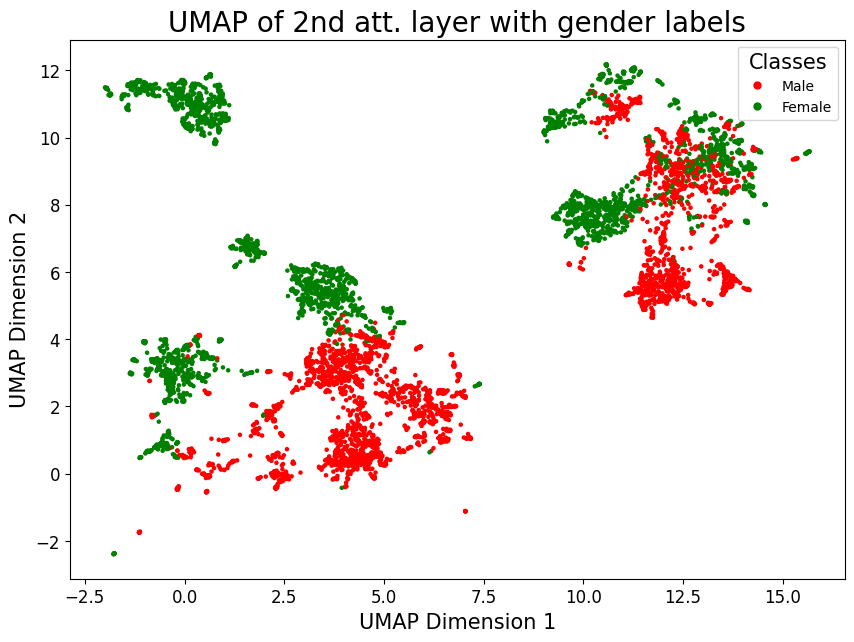

In [21]:
# UMAP Projection
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=69)
umap_embeddings = umap_reducer.fit_transform(hook2_n)

# Determine colormap and handle for two-class or multi-class labels
unique_labels = np.unique(gender_bin)
cmap = ListedColormap(["red", "green"])
# Plot UMAP
plt.figure(figsize=(10, 7))
scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap=cmap, s=5, label=unique_labels)

# Add legend for two-class data
handles = []
for i, label in enumerate(unique_labels):
    handles.append(plt.Line2D([], [], color=cmap(i), marker='o', linestyle='', markersize=5, label=f"{'Female' if label else 'Male'}"))
plt.legend(handles=handles, title="Classes", fontsize=10, title_fontsize=15)

# Optional: Add colorbar for multi-class data
# plt.colorbar(scatter)
plt.title('UMAP of 2nd att. layer with gender labels',fontsize = 20)
plt.xlabel("UMAP Dimension 1", fontsize = 15)
plt.ylabel("UMAP Dimension 2", fontsize = 15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('UMAP_gender.png')
plt.show()

In [ ]:
def normalize_origins(origins):
    """
    Normalize detailed origins into broader categories (e.g., continents or countries).
    """
    origin_mapping = {
        "Africa": "Africa",
        "Egypt": "Africa",
        "South Africa": "Africa",
        "Asia": "Asia",
        "China": "Asia",
        "India": "Asia",
        "South Korea": "Asia",
        "Europe": "Europe",
        "Denmark": "Europe",
        "France": "Europe",
        "Spanien": "Europe",
        "Germany": "Europe",
        "Italy": "Europe",
        "Poland": "Europe",
        "Spain": "Europe",
        "Syria": "Middle East",
        "Brazil": "South America"
    }
    # Map each origin to its normalized category
    return np.array([origin_mapping[origin.split(", ")[1]] for origin in origins])
    
def create_origin_color_mapping(unique_origins):
    """
    Assign unique colors to normalized origin categories.
    """
    num_origins = len(unique_origins)
    cmap = colormaps['tab20']  # Use 'tab20' for diverse colors
    colors = [cmap(i / num_origins) for i in range(num_origins)]
    return {origin: colors[i] for i, origin in enumerate(unique_origins)}

def plot_umap_with_origins(features, origins, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection by Origin"):
    """
    Plot UMAP embeddings colored by normalized origin categories.
    """
    # Normalize origins
    grouped_origins = normalize_origins(origins)

    # Create unique label-color mapping
    unique_origins = np.unique(grouped_origins)
    color_mapping = create_origin_color_mapping(unique_origins)

    # Map grouped origins to colors
    origin_colors = np.array([color_mapping[origin] for origin in grouped_origins])

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)
    
    # Plot UMAP
    plt.figure(figsize=(10, 7))
    for origin, color in color_mapping.items():
        mask = grouped_origins == origin
        plt.scatter(umap_embeddings[mask, 0], umap_embeddings[mask, 1], c=[color], label=origin, s=5)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Origins")
    plt.title(title)
    plt.xlabel("UMAP Dimension 1")
    plt.ylabel("UMAP Dimension 2")
    plt.show()
    
plot_umap_with_origins(hook1_n, origins)

# Score graphs

In [12]:
from sklearn.neighbors import NearestNeighbors

def nn_metric_ratio(data, labels, min_nn=10):
    """
    Computes a clustering metric based on nearest neighbors.
    
    Instead of counting points that satisfy a threshold, the metric adds the 
    ratio of correctly labeled neighbors to the score.
    
    Parameters:
        data (numpy.ndarray): The dataset (n_samples x n_features).
        labels (numpy.ndarray): Class labels for each sample.
        min_nn (int): Minimum number of nearest neighbors to consider.
    
    Returns:
        float: A clustering score between 0 (worst) and 1 (perfect clustering).
    """
    # Find the nearest neighbors
    nbrs = NearestNeighbors(n_neighbors=min_nn + 1).fit(data)
    _, indices = nbrs.kneighbors(data)
    
    # Compute the mismatch ratio for each point
    mismatch_ratios = np.array([
        np.mean(labels[neighbors[1:]] != labels[i]) for i, neighbors in enumerate(indices)
    ])
    
    # Compute the score as 1 minus the average mismatch ratio
    metric = 1 - np.mean(mismatch_ratios)
    return metric

In [11]:
def fisher_metric_norm(td, labels_np, norm_order=2):
    """
    Computes a Fisher-inspired class separability metric using vector norms for higher-dimensional data.

    Parameters:
    - td: numpy.ndarray
        The input data, where rows are samples and columns are features.
    - labels_np: numpy.ndarray
        Array of class labels corresponding to the rows of `td`.
    - norm_order: int or float, optional (default=2)
        The order of the norm to use. For example:
        - norm_order=2 corresponds to the Euclidean norm.
        - norm_order=1 corresponds to the Manhattan norm.
        - norm_order=np.inf corresponds to the maximum norm.

    Returns:
    - float
        The Fisher-inspired metric, representing class separability.
    """
    u = np.unique(labels_np)
    om = np.mean(td, axis=0)

    # Zero mean the data (operate on a copy to avoid side effects)
    td_centered = td - om

    S_W = 0  # Within-class scatter (as a norm)
    S_B = 0  # Between-class scatter (as a norm)

    # Compute the within-class and between-class scatter metrics
    for cls in u:
        class_data = td_centered[labels_np == cls]
        class_mean = np.mean(class_data, axis=0)
        n_i = class_data.shape[0]

        # Center the class data
        class_data_centered = class_data - class_mean

        # Within-class scatter (sum of norms of deviations from class mean)
        S_W += np.sum(np.linalg.norm(class_data_centered, ord=norm_order, axis=1)**norm_order)

        # Between-class scatter (norm of deviations of class means from overall mean)
        S_B += n_i * (np.linalg.norm(class_mean, ord=norm_order)**norm_order)

    # Normalize by the number of samples
    S_W /= td.shape[0]
    S_B /= td.shape[0]

    # Avoid division by zero
    if S_W == 0:
        raise ValueError("Within-class scatter is zero. Cannot compute Fisher metric.")

    return S_B / S_W

In [10]:
def fisher_metric(td, labels_np):
    u = np.unique(labels_np)
    om = np.mean(td, axis=0)

    # Zero mean the data
    td -= om

    S_W = np.zeros(td.shape[1])
    S_B = np.zeros(td.shape[1])
    
    
    # Compute the within-class and between-class scatter matrices
    for i, cls in enumerate(u):
        class_data = td[labels_np == cls]
        class_mean = np.mean(class_data, axis=0)
        n_i = class_data.shape[0]

        # Center the class data
        class_data -= class_mean

        # Within class variance
        S_W += np.sum(class_data**2, axis=0)
        
        S_B += n_i * class_mean**2
    
    S_B /= td.shape[0]
    S_W /= td.shape[0]
    
    #print(f'\t\tBetween: {S_B.sum():.2f}')
    #print(f'\t\tWithin: {S_W.sum():.2f}')
    #print(f'\t\tOut: {(S_B / S_W).sum():.2f}')
    
    return (S_B / S_W).sum()
    #return S_B, S_W

#test(data,labels)
print(fisher_metric(hookn[12], labels_np))
print(fisher_metric(hookn[7], labels_np))
print(fisher_metric(umap_hook8, labels_np))
print(fisher_metric(umap_hook12, labels_np))

NameError: name 'hookn' is not defined

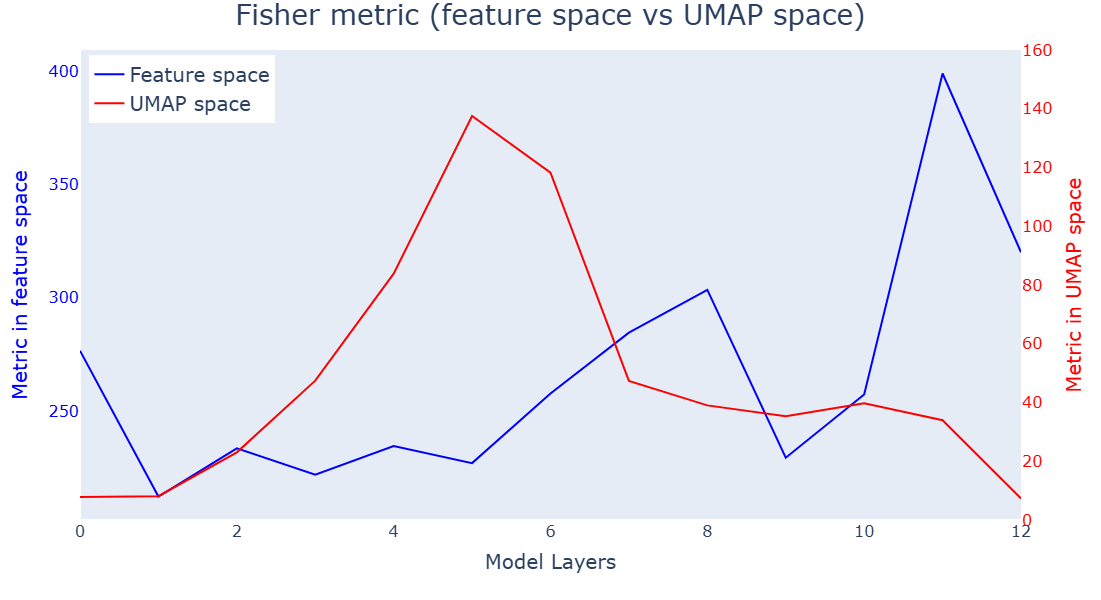

In [71]:
import plotly.graph_objects as go
scores1 = []
scores2 = []

# Assuming fhookn and hookn are defined and nn_metric_ratio is implemented
for h in hookn:
    metric1 = fisher_metric(h, labels_np)
    scores1.append(metric1)

for h in umap_hookn:
    metric2 = fisher_metric(h, labels_np)
    scores2.append(metric2)

layers = range(0, len(scores1))

# Create the plot using Plotly with dual y-axes
fig = go.Figure()

# Plot the scores for the fine-tuned model on the primary y-axis (left)
fig.add_trace(go.Scatter(x=list(layers), y=scores1, mode='lines', name='Feature space', line=dict(color='blue')))

# Plot the scores for the pre-trained model on the secondary y-axis (right)
fig.add_trace(go.Scatter(x=list(layers), y=scores2, mode='lines', name='UMAP space', line=dict(color='red'),
                         yaxis='y2'))

# Update layout settings
fig.update_layout(
    title=dict(text='Fisher metric (feature space vs UMAP space)', x=0.5, xanchor='center'),
    xaxis_title='Model Layers',
    yaxis_title='Metric in feature space',
    yaxis2=dict(
        title='Metric in UMAP space',
        overlaying='y',
        side='right',
        showgrid=False,
        color='red',
        range=[0,160],
        tickfont=dict(size=16)
    ), 
    title_font=dict(size=28),
    xaxis_title_font=dict(size=20),
    yaxis_title_font=dict(size=20),
    yaxis2_title_font=dict(size=20),
    margin=dict(t=50),
    showlegend=True,
    xaxis=dict(showgrid=False, tickfont=dict(size=16)),
    yaxis=dict(showgrid=False, color='blue', tickfont=dict(size=16)),
    width=800, height=600,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        font=dict(size=20)) 
)
# Show the figure
fig.show()

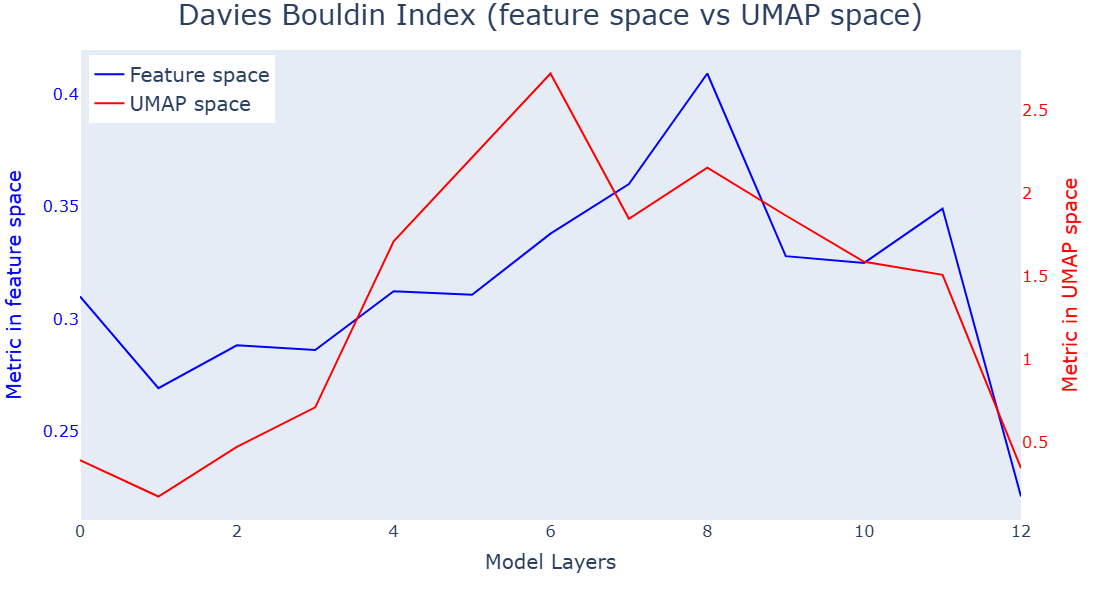

In [72]:
import plotly.graph_objects as go
scores1 = []
scores2 = []

# Assuming fhookn and hookn are defined and nn_metric_ratio is implemented
for h in hookn:
    metric1 = 1/davies_bouldin_score(h, labels_np)
    scores1.append(metric1)

for h in umap_hookn:
    metric2 = 1/davies_bouldin_score(h, labels_np)
    scores2.append(metric2)

layers = range(0, len(scores1))

# Create the plot using Plotly with dual y-axes
fig = go.Figure()

# Plot the scores for the fine-tuned model on the primary y-axis (left)
fig.add_trace(go.Scatter(x=list(layers), y=scores1, mode='lines', name='Feature space', line=dict(color='blue')))

# Plot the scores for the pre-trained model on the secondary y-axis (right)
fig.add_trace(go.Scatter(x=list(layers), y=scores2, mode='lines', name='UMAP space', line=dict(color='red'),
                         yaxis='y2'))

# Update layout settings
fig.update_layout(
    title=dict(text='Davies Bouldin Index (feature space vs UMAP space)', x=0.5, xanchor='center'),
    xaxis_title='Model Layers',
    yaxis_title='Metric in feature space',
    yaxis2=dict(
        title='Metric in UMAP space',
        overlaying='y',
        side='right',
        showgrid=False,
        color='red',
        tickfont=dict(size=16)
    ), 
    title_font=dict(size=28),
    xaxis_title_font=dict(size=20),
    yaxis_title_font=dict(size=20),
    yaxis2_title_font=dict(size=20),
    margin=dict(t=50),
    showlegend=True,
    xaxis=dict(showgrid=False, tickfont=dict(size=16)),
    yaxis=dict(showgrid=False, color='blue', tickfont=dict(size=16)),
    width=800, height=600,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        font=dict(size=20)) 
)
# Show the figure
fig.show()

In [73]:
scores1 = []
scores2 = []
for h in hookn:
    metric1 = nn_metric_ratio(h, labels_np)
    scores1.append(metric1)
for h in umap_hookn:
    metric2 = nn_metric_ratio(h, labels_np)
    scores2.append(metric2)
layers = range(0, len(scores1))

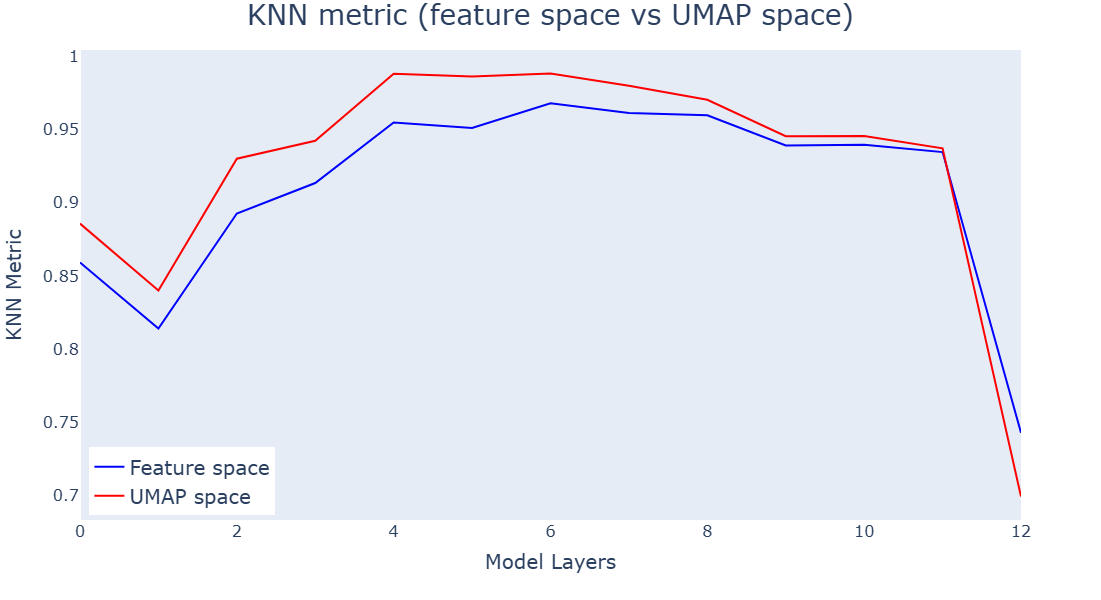

In [53]:
# Create the plot using Plotly
fig = go.Figure()

# Plot the scores for the fine-tuned model
fig.add_trace(go.Scatter(x=list(layers), y=scores1, mode='lines', name='Feature space', line=dict(color='blue')))

# Plot the scores for the pre-trained model
fig.add_trace(go.Scatter(x=list(layers), y=scores2, mode='lines', name='UMAP space', line=dict(color='red')))

# Update layout settings
fig.update_layout(
    title=dict(text='KNN metric (feature space vs UMAP space)', x=0.5, xanchor='center'),
    xaxis_title='Model Layers',
    yaxis_title='KNN Metric',
    showlegend=True,
    xaxis=dict(showgrid=False, tickfont=dict(size=16)),
    yaxis=dict(showgrid=False, tickfont=dict(size=16)),
    xaxis_title_font=dict(size=20),
    yaxis_title_font=dict(size=20),
    width=800, height=600,
    legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01,
    font=dict(size=20)),
    title_font=dict(size=28),
    margin=dict(t=50),
)
fig.show()

### UMAP of model2 (fine-tuned) (NOT IN USE)

In [5]:
# Load saved model
model2 = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base", num_labels=10)
model2.load_state_dict(torch.load("seq-class-fine.pth", weights_only=True))
model2.to(device)
model2.eval()

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1-4): 4 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (projection): Linear(in_features=512, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)


In [6]:
# Hook features
fhook0, fhook0_s = register_hook(model2.wav2vec2.feature_projection)
fhook1, fhook1_s = register_hook(model2.wav2vec2.encoder.layers[0].attention)
fhook2, fhook2_s = register_hook(model2.wav2vec2.encoder.layers[1].attention)
fhook3, fhook3_s = register_hook(model2.wav2vec2.encoder.layers[2].attention)
fhook4, fhook4_s = register_hook(model2.wav2vec2.encoder.layers[3].attention)
fhook5, fhook5_s = register_hook(model2.wav2vec2.encoder.layers[4].attention)
fhook6, fhook6_s = register_hook(model2.wav2vec2.encoder.layers[5].attention)
fhook7, fhook7_s = register_hook(model2.wav2vec2.encoder.layers[6].attention)
fhook8, fhook8_s = register_hook(model2.wav2vec2.encoder.layers[7].attention)
fhook9, fhook9_s = register_hook(model2.wav2vec2.encoder.layers[8].attention)
fhook10, fhook10_s = register_hook(model2.wav2vec2.encoder.layers[9].attention)
fhook11, fhook11_s = register_hook(model2.wav2vec2.encoder.layers[10].attention)
fhook12, fhook12_s = register_hook(model2.wav2vec2.encoder.layers[11].attention)

data_dict = forward_pass(model2, test_loader, metadata)

# Remove the hook after extraction
fhook0.remove()
fhook1.remove()
fhook2.remove()
fhook3.remove()
fhook4.remove()
fhook5.remove()
fhook6.remove()
fhook7.remove()
fhook8.remove()
fhook9.remove()
fhook10.remove()
fhook11.remove()
fhook12.remove()

# Stack the collected features and labels
fhook0_s = torch.cat(fhook0_s, dim=0)
fhook1_s = torch.cat(fhook1_s, dim=0)
fhook2_s = torch.cat(fhook2_s, dim=0)
fhook3_s = torch.cat(fhook3_s, dim=0)
fhook4_s = torch.cat(fhook4_s, dim=0)
fhook5_s = torch.cat(fhook5_s, dim=0)
fhook6_s = torch.cat(fhook6_s, dim=0)
fhook7_s = torch.cat(fhook7_s, dim=0)
fhook8_s = torch.cat(fhook8_s, dim=0)
fhook9_s = torch.cat(fhook9_s, dim=0)
fhook10_s = torch.cat(fhook10_s, dim=0)
fhook11_s = torch.cat(fhook11_s, dim=0)
fhook12_s = torch.cat(fhook12_s, dim=0)

labels = [entry['label'] for entry in data_dict]
labels_np = np.array(labels)
metadata_dict = [entry['metadata'] for entry in data_dict]
speaker_ids = [entry['speaker_id'] for entry in data_dict]
sid_np = np.array(speaker_ids)

# Convert to NumPy for UMAP
fhook0_n = fhook0_s.cpu().numpy()
fhook1_n = fhook1_s.cpu().numpy()
fhook2_n = fhook2_s.cpu().numpy()
fhook3_n = fhook3_s.cpu().numpy()
fhook4_n = fhook4_s.cpu().numpy()
fhook5_n = fhook5_s.cpu().numpy()
fhook6_n = fhook6_s.cpu().numpy()
fhook7_n = fhook7_s.cpu().numpy()
fhook8_n = fhook8_s.cpu().numpy()
fhook9_n = fhook9_s.cpu().numpy()
fhook10_n = fhook10_s.cpu().numpy()
fhook11_n = fhook11_s.cpu().numpy()
fhook12_n = fhook12_s.cpu().numpy()

fhookn = [fhook0_n, fhook1_n, fhook2_n, fhook3_n, fhook4_n, fhook5_n, fhook6_n, fhook7_n, fhook8_n, fhook9_n, fhook10_n, fhook11_n, fhook12_n]

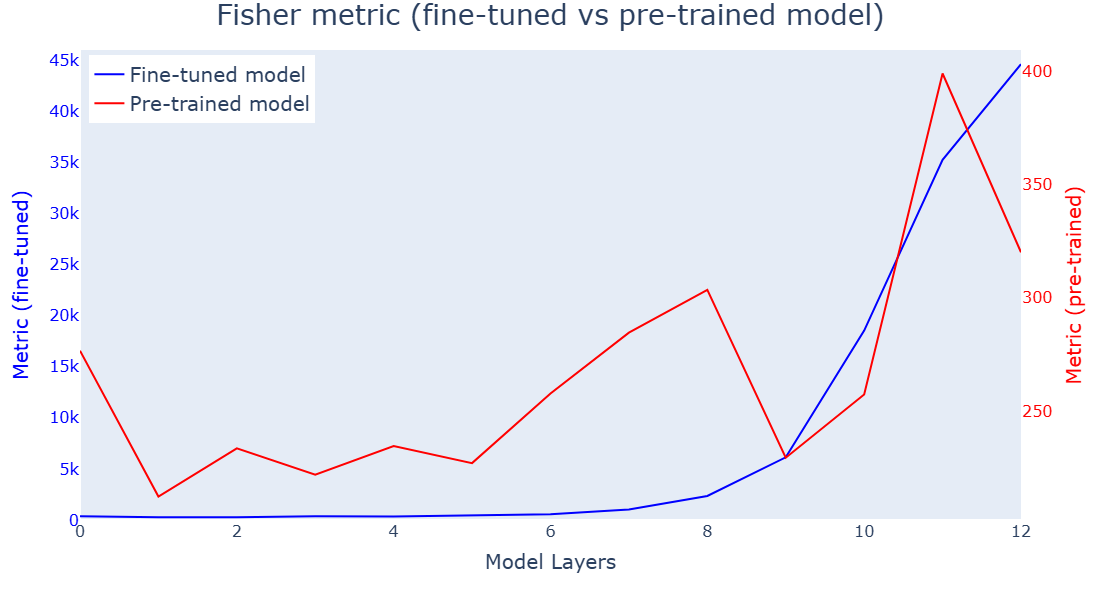

In [74]:
scores1 = []
scores2 = []

# Assuming fhookn and hookn are defined and nn_metric_ratio is implemented
for h in fhookn:
    metric1 = fisher_metric(h, labels_np)
    scores1.append(metric1)

for h in hookn:
    metric2 = fisher_metric(h, labels_np)
    scores2.append(metric2)

layers = range(0, len(scores1))

# Create the plot using Plotly with dual y-axes
fig = go.Figure()

# Plot the scores for the fine-tuned model on the primary y-axis (left)
fig.add_trace(go.Scatter(x=list(layers), y=scores1, mode='lines', name='Fine-tuned model', line=dict(color='blue')))

# Plot the scores for the pre-trained model on the secondary y-axis (right)
fig.add_trace(go.Scatter(x=list(layers), y=scores2, mode='lines', name='Pre-trained model', line=dict(color='red'), yaxis='y2'))

# Update layout settings
fig.update_layout(
    title=dict(text='Fisher metric (fine-tuned vs pre-trained model)', x=0.5, xanchor='center'),
    xaxis_title='Model Layers',
    yaxis_title='Metric (fine-tuned)',
    yaxis2=dict(
        title='Metric (pre-trained)',
        overlaying='y',
        side='right',
        showgrid=False,
        color='red',
        tickfont=dict(size=16)
    ), 
    title_font=dict(size=28),
    xaxis_title_font=dict(size=20),
    yaxis_title_font=dict(size=20),
    yaxis2_title_font=dict(size=20),
    margin=dict(t=50),
    showlegend=True,
    xaxis=dict(showgrid=False, tickfont=dict(size=16)),
    yaxis=dict(showgrid=False, color='blue', tickfont=dict(size=16), range=[0,46000]),
    width=800, height=600,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        font=dict(size=20)) 
)
# Show the figure
fig.show()

In [65]:
scores1 = []
scores2 = []

# Assuming fhookn and hookn are defined and nn_metric_ratio is implemented
for h in fhookn:
    metric1 = 1/davies_bouldin_score(h, labels_np)
    scores1.append(metric1)

for h in hookn:
    metric2 = 1/davies_bouldin_score(h, labels_np)
    scores2.append(metric2)

layers = range(0, len(scores1))

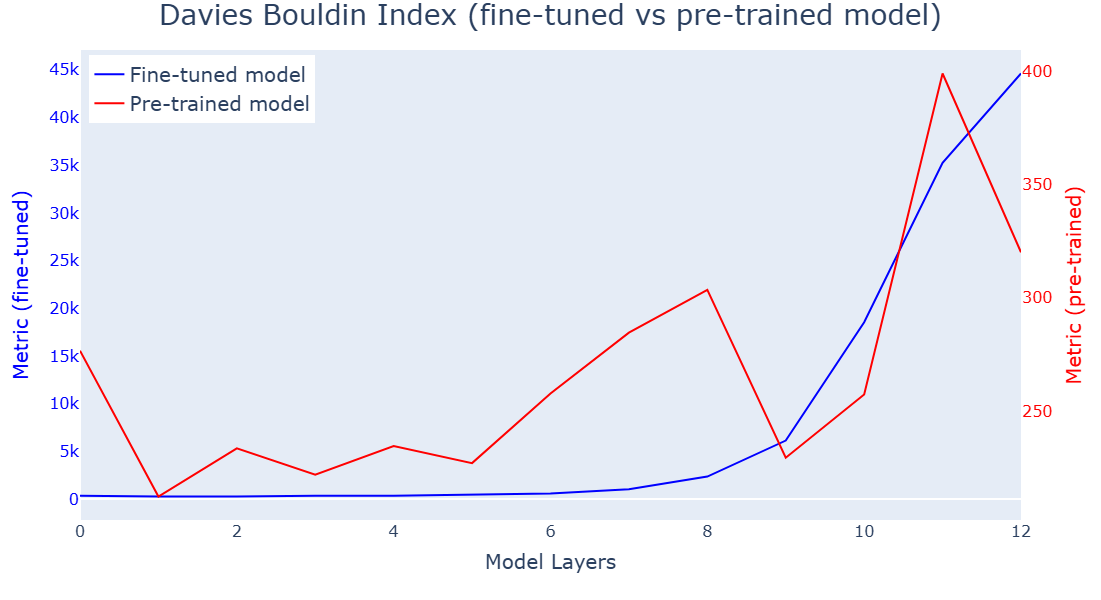

In [75]:
# Create the plot using Plotly with dual y-axes
fig = go.Figure()

# Plot the scores for the fine-tuned model on the primary y-axis (left)
fig.add_trace(go.Scatter(x=list(layers), y=scores1, mode='lines', name='Fine-tuned model', line=dict(color='blue')))

# Plot the scores for the pre-trained model on the secondary y-axis (right)
fig.add_trace(go.Scatter(x=list(layers), y=scores2, mode='lines', name='Pre-trained model', line=dict(color='red'), yaxis='y2'))

# Update layout settings
fig.update_layout(
    title=dict(text='Davies Bouldin Index (fine-tuned vs pre-trained model)', x=0.5, xanchor='center'),
    xaxis_title='Model Layers',
    yaxis_title='Metric (fine-tuned)',
    yaxis2=dict(
        title='Metric (pre-trained)',
        overlaying='y',
        side='right',
        showgrid=False,
        color='red',
        tickfont=dict(size=16)
    ), 
    title_font=dict(size=28),
    xaxis_title_font=dict(size=20),
    yaxis_title_font=dict(size=20),
    yaxis2_title_font=dict(size=20),
    margin=dict(t=50),
    showlegend=True,
    xaxis=dict(showgrid=False, tickfont=dict(size=16)),
    yaxis=dict(showgrid=False, color='blue', tickfont=dict(size=16)),
    width=800, height=600,
    legend=dict(
        yanchor="top",
        y=0.99,
        xanchor="left",
        x=0.01,
        font=dict(size=20)) 
)
# Show the figure
fig.show()

In [69]:
scores1 = []
scores2 = []
for h in fhookn:
    metric1 = nn_metric_ratio(h, labels_np)
    scores1.append(metric1)

for h in hookn:
    metric2 = nn_metric_ratio(h, labels_np)
    scores2.append(metric2)

layers = range(0, len(scores1))

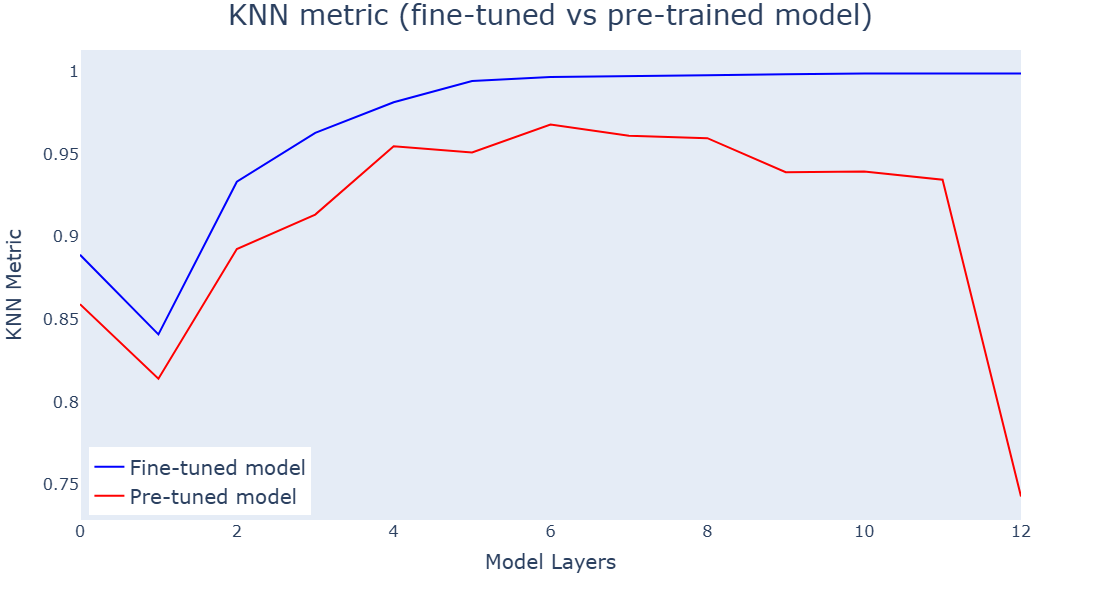

In [70]:
# Create the plot using Plotly
fig = go.Figure()

# Plot the scores for the fine-tuned model
fig.add_trace(go.Scatter(x=list(layers), y=scores1, mode='lines', name='Fine-tuned model', line=dict(color='blue')))

# Plot the scores for the pre-trained model
fig.add_trace(go.Scatter(x=list(layers), y=scores2, mode='lines', name='Pre-tuned model', line=dict(color='red')))

# Update layout settings
fig.update_layout(
    title=dict(text='KNN metric (fine-tuned vs pre-trained model)', x=0.5, xanchor='center'),
    xaxis_title='Model Layers',
    yaxis_title='KNN Metric',
    showlegend=True,
    xaxis=dict(showgrid=False, tickfont=dict(size=16)),
    yaxis=dict(showgrid=False, tickfont=dict(size=16)),
    xaxis_title_font=dict(size=20),
    yaxis_title_font=dict(size=20),
    width=800, height=600,
    legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01,
    font=dict(size=20)),
    title_font=dict(size=28),
    margin=dict(t=50),
)
fig.show()

# UMAP OF ALL LAYERS

In [77]:
import numpy as np
import umap
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import cm

def plot_umap(features, labels, n_neighbors=15, min_dist=0.1, n_components=2, random_state=42, title="UMAP Projection of Features", show=True, save=False, idx=None):
    # Ensure 'features' and 'labels' are numpy arrays
    assert isinstance(features, np.ndarray), "Features must be a numpy array"
    assert isinstance(labels, np.ndarray), "Labels must be a numpy array"

    # UMAP Projection
    umap_reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, n_components=n_components, random_state=random_state)
    umap_embeddings = umap_reducer.fit_transform(features)

    # Determine colormap for multi-class labels
    unique_labels = np.unique(labels)
    cmap = cm.get_cmap('tab10', len(unique_labels))  # Use 'tab10' colormap for any number of classes

    # Plot UMAP
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=labels, cmap=cmap, s=5)

    # Create custom legend based on unique labels
    handles = []
    for i, label in enumerate(unique_labels):
        handles.append(Line2D([0], [0], color=cmap(i), marker='o', linestyle='', markersize=5, label=f"Class {label}"))
    plt.legend(handles=handles, title="Classes", fontsize=10, title_fontsize=15)

    # Customize plot labels and title
    plt.title(title,  fontsize = 20)
    plt.xlabel("UMAP Dimension 1",  fontsize = 15)
    plt.ylabel("UMAP Dimension 2",  fontsize = 15)
    
    # Save the plot if needed
    if save:
        plt.savefig(f'UMAP_{idx}.png')
    
    # Show the plot
    if show:
        plt.show()

/tmp/ipykernel_685563/1260916256.py:33: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/tmp/ipykernel_685563/1260916256.py:33: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

/tmp/ipykernel_685563/1260916256.py:33: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



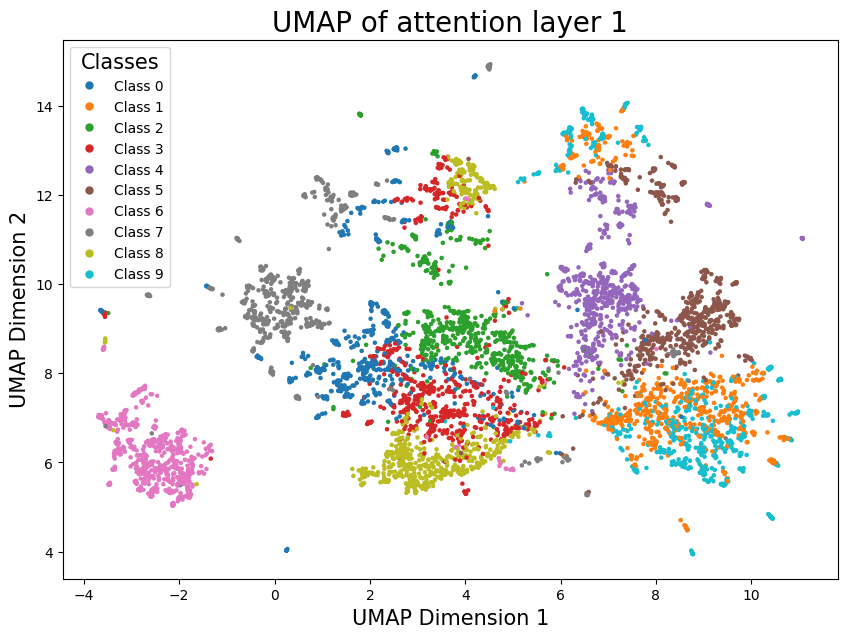

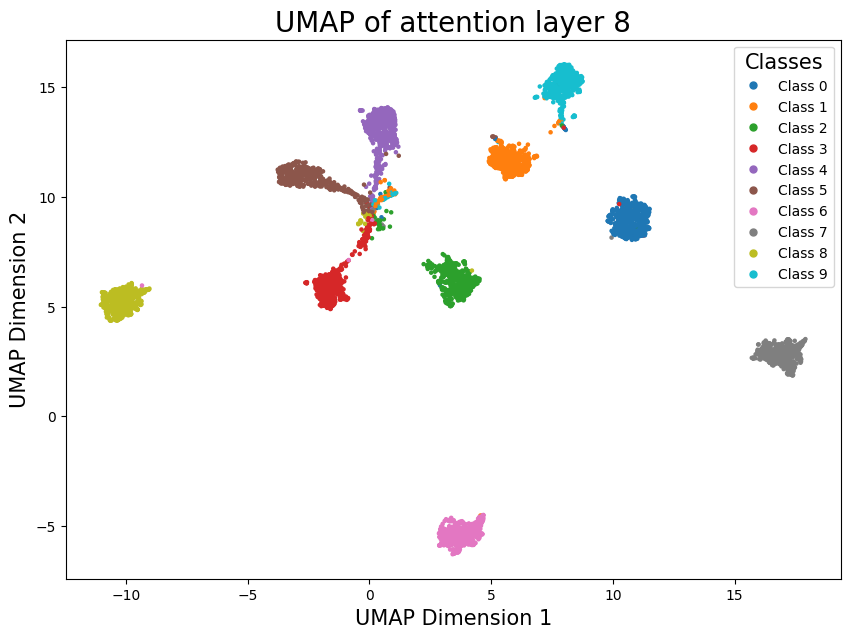

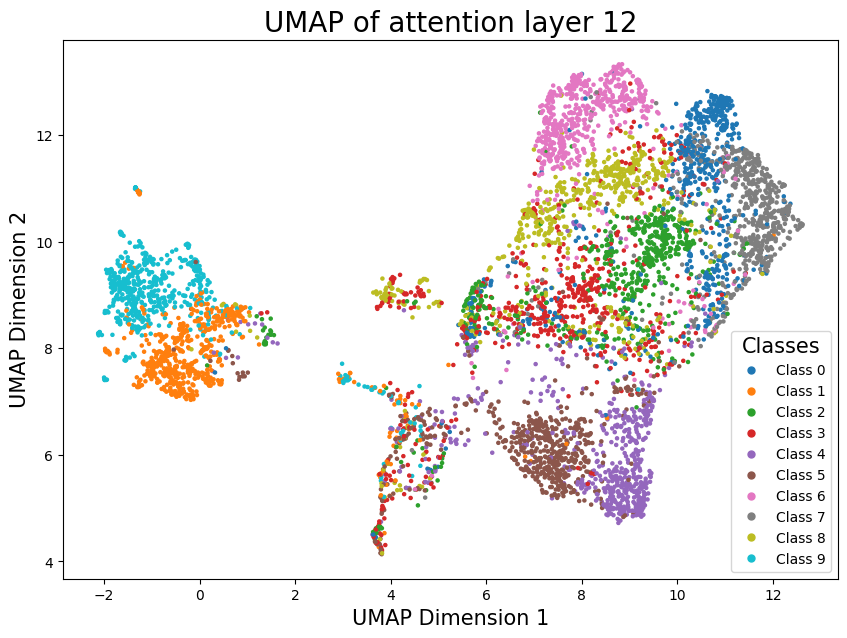

In [78]:
plot_umap(hookn[1], labels_np, title=f"UMAP of attention layer 1", random_state=69, show=False, save=True, idx=1)
plot_umap(hookn[8], labels_np, title=f"UMAP of attention layer 8", random_state=69, show=False, save=True, idx=8)
plot_umap(hookn[12], labels_np, title=f"UMAP of attention layer 12", random_state=69, show=False, save=True, idx=12)

/tmp/ipykernel_685563/708004996.py:12: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



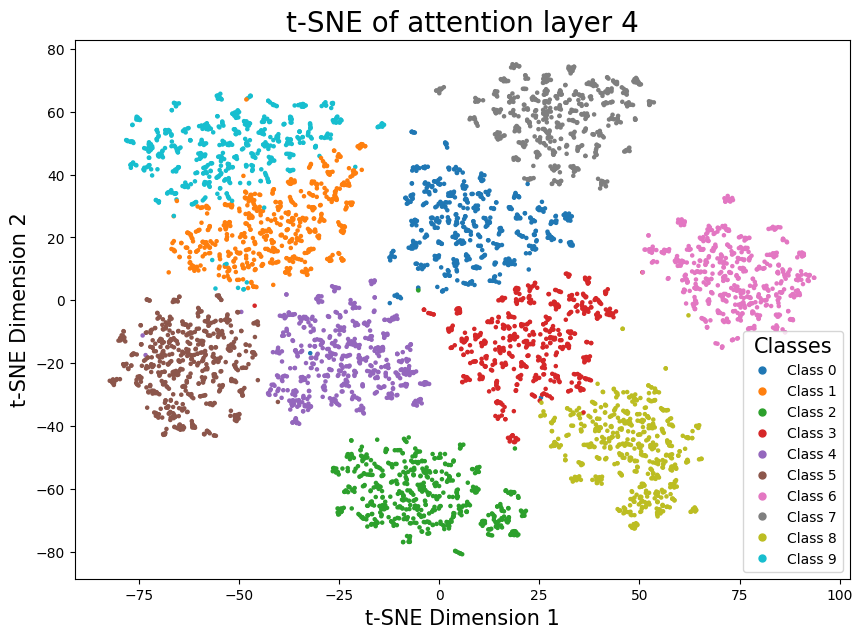

/tmp/ipykernel_685563/1260916256.py:33: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



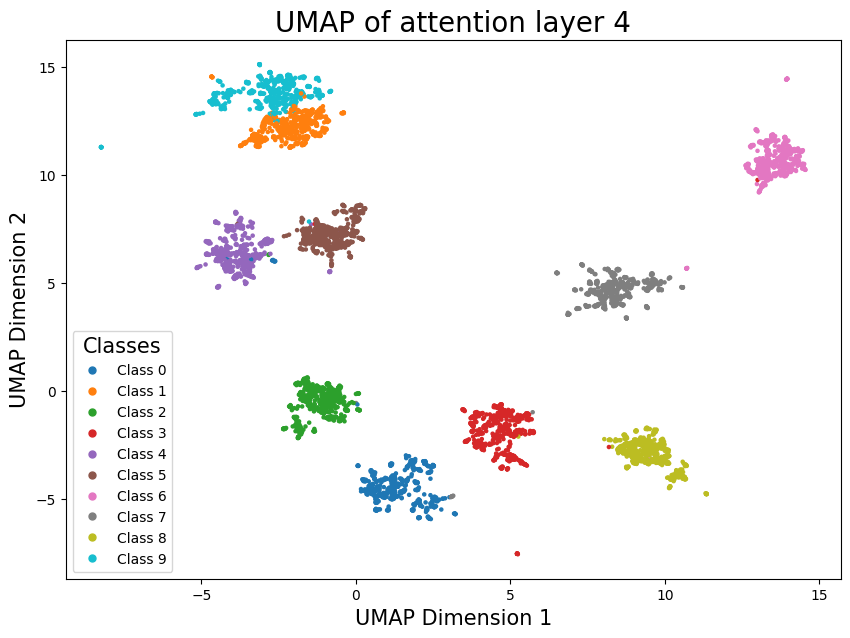

In [80]:
def plot_tsne(features, labels,n_components=2, perplexity=30, learning_rate=200, random_state=42, max_iter=1000, title="T-SNE Projection of Features", show=True, save=False, idx=None):
    # Ensure 'features' and 'labels' are numpy arrays
    assert isinstance(features, np.ndarray), "Features must be a numpy array"
    assert isinstance(labels, np.ndarray), "Labels must be a numpy array"

    # UMAP Projection
    tsne = TSNE(n_components=n_components, perplexity=perplexity, learning_rate=learning_rate, max_iter=max_iter, random_state=random_state)
    tsne_embeddings = tsne.fit_transform(features)

    # Determine colormap for multi-class labels
    unique_labels = np.unique(labels)
    cmap = cm.get_cmap('tab10', len(unique_labels))  # Use 'tab10' colormap for any number of classes

    # Plot UMAP
    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=labels, cmap=cmap, s=5)

    # Create custom legend based on unique labels
    handles = []
    for i, label in enumerate(unique_labels):
        handles.append(Line2D([0], [0], color=cmap(i), marker='o', linestyle='', markersize=5, label=f"Class {label}"))
    plt.legend(handles=handles, title="Classes", fontsize=10, title_fontsize=15)

    # Customize plot labels and title
    plt.title(title,  fontsize = 20)
    plt.xlabel("t-SNE Dimension 1",  fontsize = 15)
    plt.ylabel("t-SNE Dimension 2",  fontsize = 15)
    
    # Save the plot if needed
    if save:
        plt.savefig(f'tsne_{idx}.png')
    
    # Show the plot
    if show:
        plt.show()

plot_tsne(hookn[4], labels_np, title=f"t-SNE of attention layer 4", random_state=69, show=True, save=True, idx=4)
plot_umap(hookn[4], labels_np, title=f"UMAP of attention layer 4", random_state=69, show=True, save=True, idx=4)

In [31]:
scores1 = []
scores2 = []

# Assuming fhookn and hookn are defined and nn_metric_ratio is implemented
for h in fhookn:
    metric1 = nn_metric_ratio(h, gender_bin)
    scores1.append(metric1)

for h in hookn:
    metric2 = nn_metric_ratio(h, gender_bin)
    scores2.append(metric2)

layers = range(0, len(scores1))

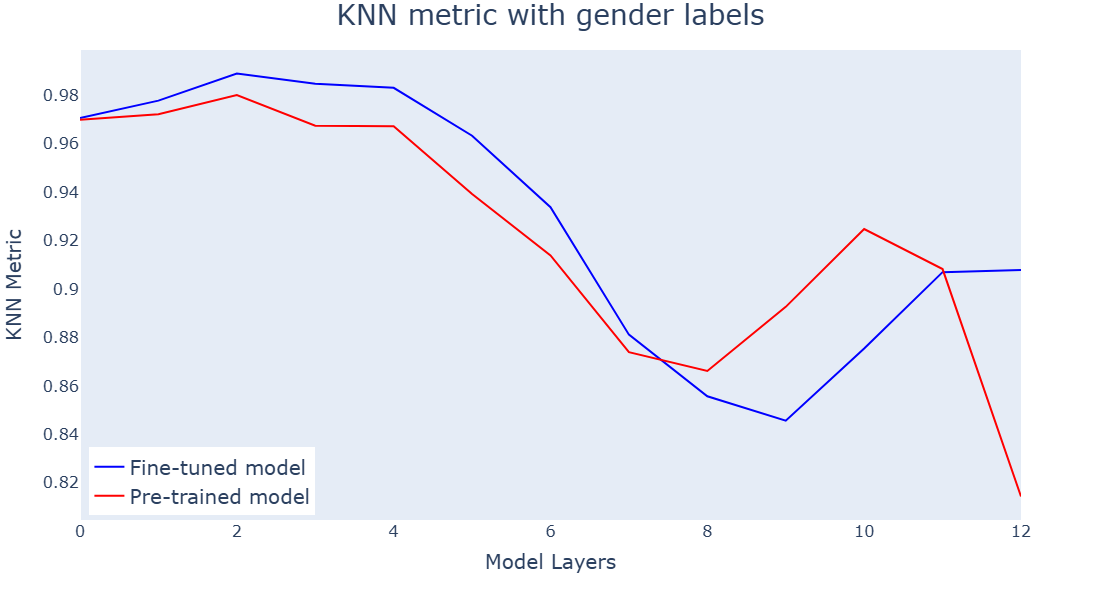

In [32]:
# Create the plot using Plotly
fig = go.Figure()

# Plot the scores for the fine-tuned model
fig.add_trace(go.Scatter(x=list(layers), y=scores1, mode='lines', name='Fine-tuned model', line=dict(color='blue')))

# Plot the scores for the pre-trained model
fig.add_trace(go.Scatter(x=list(layers), y=scores2, mode='lines', name='Pre-trained model', line=dict(color='red')))

# Update layout settings
fig.update_layout(
    title=dict(text='KNN metric with gender labels', x=0.5, xanchor='center'),
    xaxis_title='Model Layers',
    yaxis_title='KNN Metric',
    showlegend=True,
    xaxis=dict(showgrid=False, tickfont=dict(size=16)),
    yaxis=dict(showgrid=False, tickfont=dict(size=16)),
    xaxis_title_font=dict(size=20),
    yaxis_title_font=dict(size=20),
    width=800, height=600,
    legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01,
    font=dict(size=20)),
    title_font=dict(size=28),
    margin=dict(t=50),
)
fig.show()

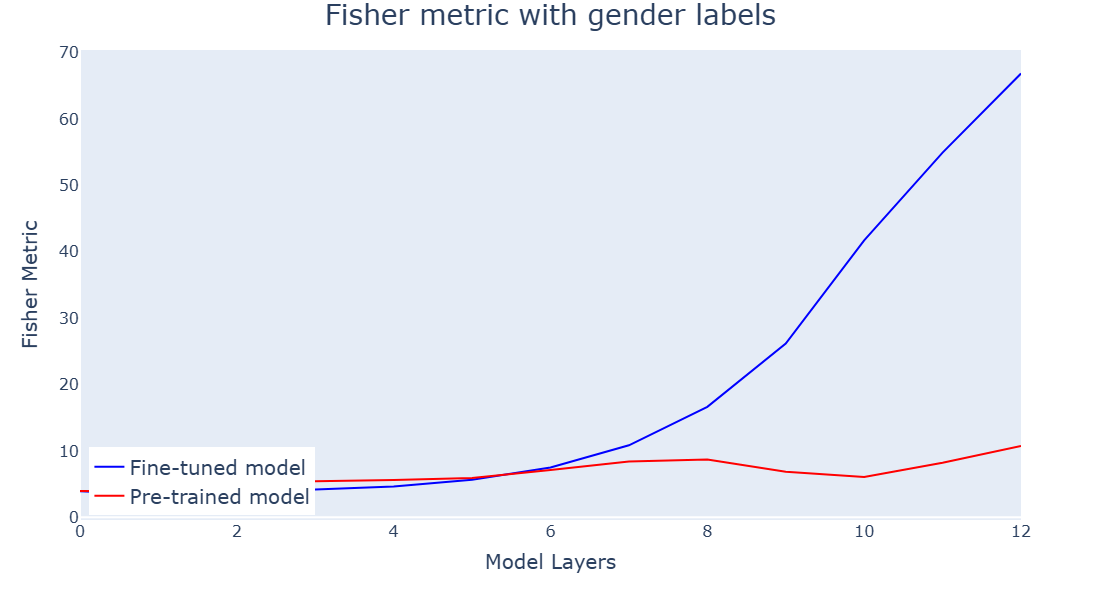

In [37]:
scores1 = []
scores2 = []

# Assuming fhookn and hookn are defined and nn_metric_ratio is implemented
for h in fhookn:
    metric1 = davies_bouldin_score(h, gender_bin)
    scores1.append(metric1)

for h in hookn:
    metric2 = davies_bouldin_score(h, gender_bin)
    scores2.append(metric2)

layers = range(0, len(scores1))

# Create the plot using Plotly
fig = go.Figure()

# Plot the scores for the fine-tuned model
fig.add_trace(go.Scatter(x=list(layers), y=scores1, mode='lines', name='Fine-tuned model', line=dict(color='blue')))

# Plot the scores for the pre-trained model
fig.add_trace(go.Scatter(x=list(layers), y=scores2, mode='lines', name='Pre-trained model', line=dict(color='red')))

# Update layout settings
fig.update_layout(
    title=dict(text='Fisher metric with gender labels', x=0.5, xanchor='center'),
    xaxis_title='Model Layers',
    yaxis_title='Fisher Metric',
    showlegend=True,
    xaxis=dict(showgrid=False, tickfont=dict(size=16)),
    yaxis=dict(showgrid=False, tickfont=dict(size=16)),#, range=[0,50]),
    xaxis_title_font=dict(size=20),
    yaxis_title_font=dict(size=20),
    width=800, height=600,
    legend=dict(
    yanchor="bottom",
    y=0.01,
    xanchor="left",
    x=0.01,
    font=dict(size=20)),
    title_font=dict(size=28),
    margin=dict(t=50),
)
fig.show()